In [1]:
import random
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
!python -m spacy download en_core_web_lg -q

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-10 00:17:17.204514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 00:17:17.204690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 00:17:17.204723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [3]:
nlp = spacy.load('en_core_web_lg')

### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


In [7]:
import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Functions

## Data Wrangling Utility Functions

In [9]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

In [10]:
def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def remove_bad_chars(text: str) -> str:
    x=re.sub('[©Ãé]','',text)
    return x

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def clean_line(text,debug=False):

  line_list=str(text).split()

  if debug==True:
    print("line:",text)
    print("str(line):",str(text))
    print("split line:",line_list)

  line_list=[remove_punctuation(word.lower()) for word in line_list]
  if debug==True:
    print("cleaned split line:",line_list)
  cleaned_line= ' '.join(line_list)

  if debug==True:
    print("rejoined line:",cleaned_line)
  return cleaned_line

In [11]:
def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc=remove_bad_chars(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [12]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    


In [13]:
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

In [14]:
def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)

In [15]:
def plot_graph(df: pd.DataFrame, show_edges: bool = False, 
               figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()

In [16]:
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10,debug=False):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    if (train_split+val_split+test_split!=1.0):
      print("Error: Train/Validation/Test split does not equal 100%")
      print("   Using split of 80/10/10")
      print()
      train_split=0.8
      val_split=0.1

    indices_or_sections = [int(train_split*len(df)), int((train_split+val_split)*len(df))]
   
    if debug==True:
      print(indices_or_sections)
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [17]:
def get_entities(sent,debug=False):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""


  for tok in nlp(sent):
    #debug
    if debug==True:
      print("tok: text: \"",tok.text,"\",   dep: ",tok.dep_)

    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [18]:
def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass

In [19]:
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

In [20]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST,fig_size=(10,10)):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [21]:
stop_words = set(stopwords.words('english'))

stop_words |= set(["shall","thy","thou","go","thee"])

for x in range(18):
  print(list(stop_words)[10*x:10*x+10])

["wasn't", 'what', 'more', 'against', 'isn', 'where', 'yours', 'themselves', 't', 'them']
['of', 'which', 'now', "isn't", 'after', 'ma', "mightn't", 'haven', 'here', 'from']
['m', 'then', 'needn', 'ours', 'into', "shouldn't", 'his', 'about', 'thy', 'do']
['does', 'itself', 'you', 'wouldn', 'the', 'over', 'those', 'our', 'most', 'same']
['too', 'when', 'thou', 'these', 'doing', 'just', 'above', 's', 'my', 'not']
['each', 'to', 'didn', 'it', 'they', 'by', 'ourselves', 'or', 'because', 'couldn']
['again', 'be', 'on', "couldn't", 'theirs', "haven't", "you're", 'whom', 'she', 'an']
['off', 'weren', 'will', 'nor', 'their', 'any', 'no', 'me', 're', 'hasn']
['having', 'than', 'is', 'mustn', "don't", 'hadn', 'who', 'am', 'himself', 'was']
['for', 'such', 'between', 'with', 'he', 'this', "hasn't", 'during', 'y', 'i']
['in', 'thee', 'had', 'as', "it's", 'doesn', 'shouldn', 'all', 'o', "didn't"]
['yourself', 'there', 'd', 'few', 'why', "should've", 'll', "aren't", "weren't", 'its']
["needn't", 'hi

# Load Data and create data frame

In [22]:
from nltk.corpus import shakespeare
nltk.download('shakespeare')

from xml.etree import ElementTree

[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


In [23]:
playtitles=[]

for playxml in shakespeare.fileids():
  curr_play = shakespeare.xml(playxml)
  playtitles.append(curr_play[0].text)

print("Play Titles:")
for x in playtitles:
  print("  ",x)

Play Titles:
   The Tragedy of Antony and Cleopatra
   A Midsummer Night's Dream
   The Tragedy of Hamlet, Prince of Denmark
   The Tragedy of Julius Caesar
   The Tragedy of Macbeth
   The Merchant of Venice
   The Tragedy of Othello, the Moor of Venice
   The Tragedy of Romeo and Juliet


In [24]:
lines_all=[]
lines_each=[]

for playxml in shakespeare.fileids():
  curr_play = shakespeare.xml(playxml)
  curr_play_lines=[str(line.text) for line in curr_play.findall('*/*/*/LINE')]
  lines_each.append(curr_play_lines)
  lines_all=lines_all+curr_play_lines

lines_all_one=" ".join(lines_all)

print("Number of plays: ",len(playtitles))
print()
print("Lines per Play:")
for x in range(len(playtitles)):
  print(playtitles[x],":",len(lines_each[x]))

print()
print("Total lines: ",len(lines_all))

Number of plays:  8

Lines per Play:
The Tragedy of Antony and Cleopatra : 3560
A Midsummer Night's Dream : 2159
The Tragedy of Hamlet, Prince of Denmark : 4014
The Tragedy of Julius Caesar : 2596
The Tragedy of Macbeth : 2385
The Merchant of Venice : 2663
The Tragedy of Othello, the Moor of Venice : 3556
The Tragedy of Romeo and Juliet : 3093

Total lines:  24026


In [25]:
words_all=""
words_each=[]

for curr_play in lines_each:
  curr_play=[str(line) for line in curr_play]
  curr_words=' '.join(curr_play)

  words_each.append(curr_words)
  words_all=words_all+curr_words

print("Number of plays: ",len(playtitles))
print()
print("Words per Play:")
for x in range(len(playtitles)):
  print(playtitles[x],":",len(words_each[x].split()))

print()
print("Total words: ",len(words_all.split()))

Number of plays:  8

Words per Play:
The Tragedy of Antony and Cleopatra : 23573
A Midsummer Night's Dream : 15993
The Tragedy of Hamlet, Prince of Denmark : 29400
The Tragedy of Julius Caesar : 19057
The Tragedy of Macbeth : 16359
The Merchant of Venice : 20859
The Tragedy of Othello, the Moor of Venice : 25618
The Tragedy of Romeo and Juliet : 23798

Total words:  174650


In [26]:
# put it all in a dataframe

d={'xmlfile':shakespeare.fileids(),
   'title':playtitles,
   'lines':lines_each,
   'words':words_each}

plays_df=pd.DataFrame(data=d)

print(plays_df)

        xmlfile                                       title  \
0   a_and_c.xml         The Tragedy of Antony and Cleopatra   
1     dream.xml                   A Midsummer Night's Dream   
2    hamlet.xml    The Tragedy of Hamlet, Prince of Denmark   
3  j_caesar.xml                The Tragedy of Julius Caesar   
4   macbeth.xml                      The Tragedy of Macbeth   
5  merchant.xml                      The Merchant of Venice   
6   othello.xml  The Tragedy of Othello, the Moor of Venice   
7   r_and_j.xml             The Tragedy of Romeo and Juliet   

                                               lines  \
0  [Nay, but this dotage of our general's, O'erfl...   
1  [Now, fair Hippolyta, our nuptial hour, Draws ...   
2  [Who's there?, Nay, answer me: stand, and unfo...   
3  [Hence! home, you idle creatures get you home:...   
4  [When shall we three meet again, In thunder, l...   
5  [In sooth, I know not why I am so sad:, It wea...   
6  [Tush! never tell me; I take it much 

In [27]:
plays_df['wordsClean'] = plays_df['words'].apply(lambda x :clean_line(x))

print(plays_df.wordsClean.head())

0    nay but this dotage of our generals oerflows t...
1    now fair hippolyta our nuptial hour draws on a...
2    whos there nay answer me stand and unfold your...
3    hence home you idle creatures get you home is ...
4    when shall we three meet again in thunder ligh...
Name: wordsClean, dtype: object


In [ ]:
# Tokenizes text, removes stop words, turns tokens into lemmas

plays_df['cleanedLemmas']=plays_df['wordsClean'].apply(lambda x :get_lemmas(x,stop_words))

print(plays_df.cleanedLemmas.head())

In [ ]:
plays_df['lemmasJoined']= plays_df.cleanedLemmas.apply(lambda x: ' '.join(x))

print(plays_df.lemmasJoined.head())

In [30]:
# Tokenize sentences
plays_df['raw_sentences'] = plays_df.words.apply(get_sentences)
plays_df.head(3).T

,0,1,2
xmlfile,a_and_c.xml,dream.xml,hamlet.xml
title,The Tragedy of Antony and Cleopatra,A Midsummer Night's Dream,"The Tragedy of Hamlet, Prince of Denmark"
lines,"[Nay, but this dotage of our general's, O'erfl...","[Now, fair Hippolyta, our nuptial hour, Draws ...","[Who's there?, Nay, answer me: stand, and unfo..."
words,"Nay, but this dotage of our general's O'erflow...","Now, fair Hippolyta, our nuptial hour Draws on...","Who's there? Nay, answer me: stand, and unfold..."
wordsClean,nay but this dotage of our generals oerflows t...,now fair hippolyta our nuptial hour draws on a...,whos there nay answer me stand and unfold your...
cleanedLemmas,"[nay, dotage, general, oerflow, measure, goodl...","[fair, hippolyta, nuptial, hour, draw, apace, ...","[nay, answer, stand, unfold, long, live, king,..."
lemmasJoined,nay dotage general oerflow measure goodly eye ...,fair hippolyta nuptial hour draw apace four ha...,nay answer stand unfold long live king bernard...
raw_sentences,"[Nay, but this dotage of our general's O'erflo...","[Now, fair Hippolyta, our nuptial hour, Draws ...","[Who's there?, Nay, answer me: stand, and unfo..."


In [31]:
processed_text=plays_df.cleanedLemmas.tolist()

In [32]:
corpus_text_sentences = [remove_bad_chars(y) for x in plays_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
print("Number of text sentences: ",len(corpus_text_sentences))
print("   Example sentence: ",example_sentence)

Number of text sentences:  12885
   Example sentence:  I'll set a bourn how far to be beloved.


In [33]:
fewer_text_sent=random.choices(corpus_text_sentences,k=8000)

# TF-IDF

In [34]:
def run_tfidf(cleaned_documents,important_prevalent_terms,experiment_name,
              output_vocabulary=True):
    cleaned_document_text = list(cleaned_documents)
    
    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()


    if output_vocabulary:
        with open(f'vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix, 
                               columns=vectorizer.get_feature_names_out(), 
                               index=plays_df.xmlfile)
    
    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)
    
    print()
    top50=pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(50))
    print("Top 50 terms: ",top50.index)

    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)
 
    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    print()
    print("Selected Terms TF-IDF")
    print(all_tfidf_results)
    print()

    plt.hist(doc_term_df.mean(), 100, range=(0, 8))
    
    print(f'Vocabulary size: {doc_term_df.shape[1]}')
    
    descriptors = playtitles
       
    # similarities = cosine_similarity(doc_term_df.loc[action_doc_ids], doc_term_df.loc[action_doc_ids])
    similarities = cosine_similarity(doc_term_df, doc_term_df)
    fig, ax = plt.subplots(figsize=(20, 20))
    fig.suptitle('Cosine Similarities Heatmap', fontsize=24)
    labels = playtitles
    sns.heatmap(ax=ax, data=similarities, vmin=0, vmax=1, \
                xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

    # print a second, smaller map to compare for paper purposes
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    sns.heatmap(ax=ax, data=similarities,vmin=0, vmax=1,
                xticklabels=labels, yticklabels=labels)
    plt.tick_params(left = False, right = False , labelleft = False ,\
                    labelbottom = False, bottom = False)
    plt.show()

In [35]:
selected_terms=["fate","love","death","caesar","romeo","juliet"]

,Mean TF-IDF
come,108.125
good,86.000
well,85.500
love,82.500
make,77.000
man,74.250
lord,67.500
let,65.625
say,63.625
know,63.500



Top 50 terms:  Index(['come', 'good', 'well', 'love', 'make', 'man', 'lord', 'let', 'say',
       'know', 'caesar', 'would', 'see', 'give', 'hath', 'ill', 'upon',
       'speak', 'one', 'sir', 'must', 'yet', 'may', 'like', 'take', 'tis',
       'antony', 'hear', 'think', 'night', 'time', 'tell', 'cassio', 'romeo',
       'look', 'heart', 'eye', 'hand', 'much', 'brutus', 'death', 'none',
       'mine', 'thing', 'friend', 'never', 'day', 'great', 'hamlet', 'leave'],
      dtype='object')

Selected Terms TF-IDF
fate       3.62
love      82.50
death     29.12
caesar    60.61
romeo     35.68
juliet    12.52
dtype: float64

Vocabulary size: 9641


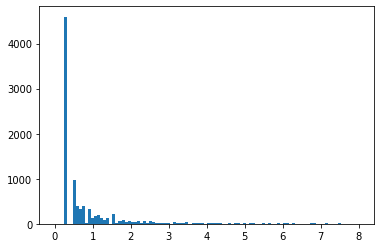

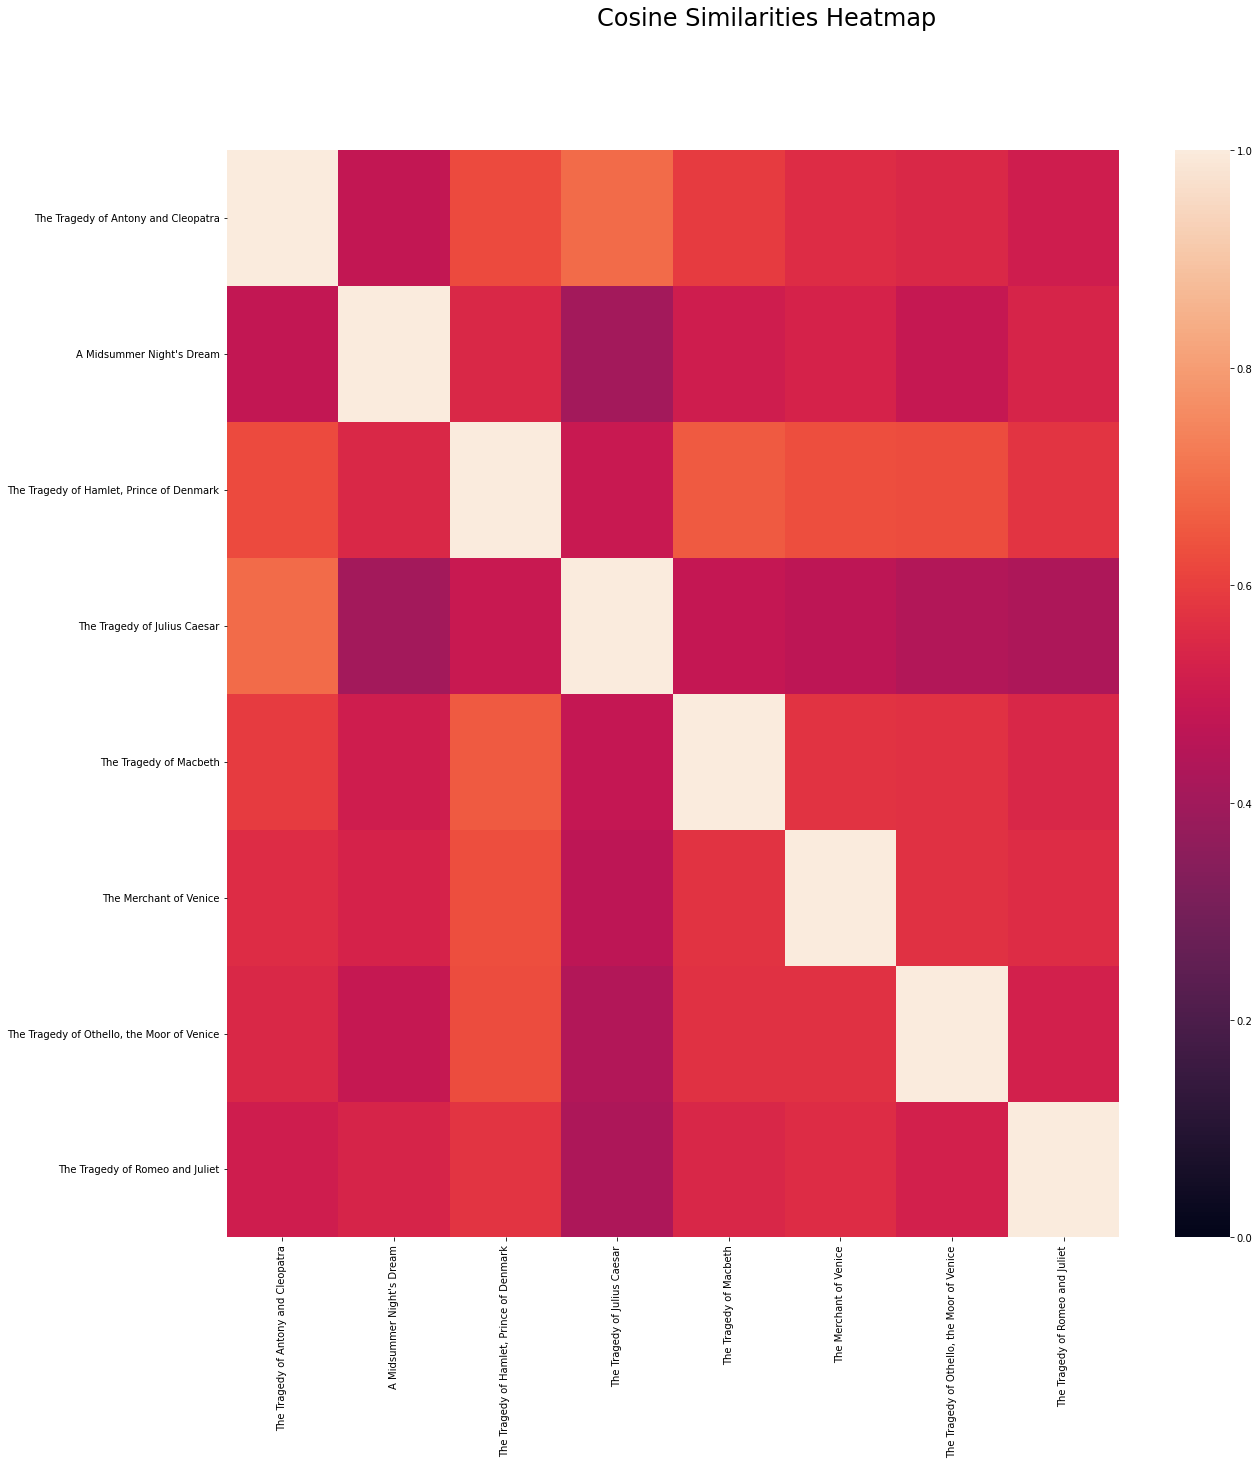

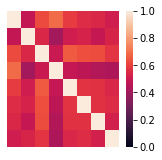

In [36]:
run_tfidf( plays_df.lemmasJoined, selected_terms, 'TFIDF')

# Create Knowledge Graphs

In [ ]:
entity_pairs = [get_entities(x) for x in tqdm(fewer_text_sent)]



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 3/8000 [00:00<04:53, 27.24it/s]

  0%|          | 7/8000 [00:00<03:53, 34.19it/s]

  0%|          | 12/8000 [00:00<03:16, 40.68it/s]

  0%|          | 18/8000 [00:00<02:48, 47.42it/s]

  0%|          | 25/8000 [00:00<02:28, 53.85it/s]

  0%|          | 31/8000 [00:00<02:31, 52.77it/s]

  0%|          | 37/8000 [00:00<02:53, 45.97it/s]

  1%|          | 43/8000 [00:00<02:41, 49.41it/s]

  1%|          | 49/8000 [00:01<02:34, 51.30it/s]

  1%|          | 56/8000 [00:01<02:38, 50.12it/s]

  1%|          | 62/8000 [00:01<02:39, 49.66it/s]

  1%|          | 68/8000 [00:01<02:35, 51.04it/s]

  1%|          | 75/8000 [00:01<02:25, 54.33it/s]

  1%|          | 82/8000 [00:01<02:18, 56.99it/s]

  1%|          | 88/8000 [00:01<02:17, 57.66it/s]

  1%|          | 95/8000 [00:01<02:12, 59.51it/s]

  1%|▏         | 102/8000 [00:01<02:08, 61.59it/s]

  1%|▏         | 109/8000 [00:02<02:08, 61.36it/s]

  1%|▏         | 116/8000 [00:02<02:13

In [ ]:
print("Number of Entity Pairs: ",len(entity_pairs))
print()
print(entity_pairs)

Number of Entity Pairs:  8000

[["e'er", 'thee'], ['I', 'monumental  alabaster'], ['Caesar', 'yet  Capitol'], ['I', 'signiory out complaints'], ['', ''], ['forth  speed', 'Mantua'], ['', ''], ['here  that', ''], ['', ''], ['daughter', 'ear'], ['o  he', 'me'], ['he', ''], ['Potations pottle Potations he', ''], ['', ''], ['hark  I', 'man'], ['eternal  curse', 'you'], ['I', 'thee'], ['she', 'devil'], ['thou', ''], ['Where  mother', ''], ['I', 'worthy  governor'], ['keepers', 'death'], ['face', 'heart'], ['Then  Lord', 'me'], ['us', 'castle'], ['', ''], ['life', ''], ['', ''], ['', ''], ['', 'fancy  head'], ['', 'sea'], ['workman', ''], ['you', 'me'], ['I', 'Parthian  darts'], ['Christian  him', 'bond'], ['fairy', ''], ['', ''], ['honest  we', 'falling  sickness'], ['I', 'horses'], ['common  body', 'varying vagabond motion'], ['small', ''], ['', 'lord'], ["wail'd  I", 'he'], ['thou shouldst', 'what'], ['', 'deep  lungs'], ['Here  like', 'arm'], ['pardon', 'business'], ['', ''], ['thou', 'm

In [ ]:
relations = [get_relation(x) for x in fewer_text_sent]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [ ]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [ ]:
kg_df.shape

(4682, 3)

In [ ]:
len(fewer_text_sent)

8000

In [ ]:
print("Number of unique sources: ", len(kg_df.source.unique()))
print(kg_df.source.value_counts()[:25])

Number of unique sources:  1697
i          643
you        264
that       143
he         129
it         117
we         113
they        65
thou        47
she         46
me          44
what        32
who         30
this        29
which       23
god         19
when  i     18
so  i       17
him         16
sir  i      14
now  i      14
us          14
caesar      14
lord  i     13
how  it     13
yet  i      12
Name: source, dtype: int64


In [ ]:
print("Number of unique edges: ", len(kg_df.edge.unique()))
print(kg_df.edge.value_counts()[:25])

Number of unique edges:  1364
is       269
have     138
let      122
be        79
know      70
give      67
make      63
tell      63
say       57
do        55
am        53
pray      53
are       52
's        49
hear      45
see       44
come      42
was       42
think     35
hath      33
take      32
go        28
find      26
had       23
leave     22
Name: edge, dtype: int64


In [ ]:
print("Number of unique targets: ", len(kg_df.target.unique()))
print(kg_df.target.value_counts()[:20])

Number of unique targets:  2139
me        171
you       164
it        125
thee      109
him        93
what       73
them       52
that       48
her        44
us         39
this       34
love       19
death      19
will       15
hand       15
caesar     14
place      14
heart      14
time       13
night      13
Name: target, dtype: int64


In [ ]:
plot_graph(kg_df, figsize=(25,25),use_circular=True)

              source target          edge
15    eternal  curse    you          deny
32               you     me  commune with
88      gentlemen  i    you       commend
89               you     me         seems
95               you    day         leave
...              ...    ...           ...
7862              he    you          know
7891               i    you       come to
7900            news    you            's
7930             you   rest           set
7980     honest  who    you       soldier

[419 rows x 3 columns]


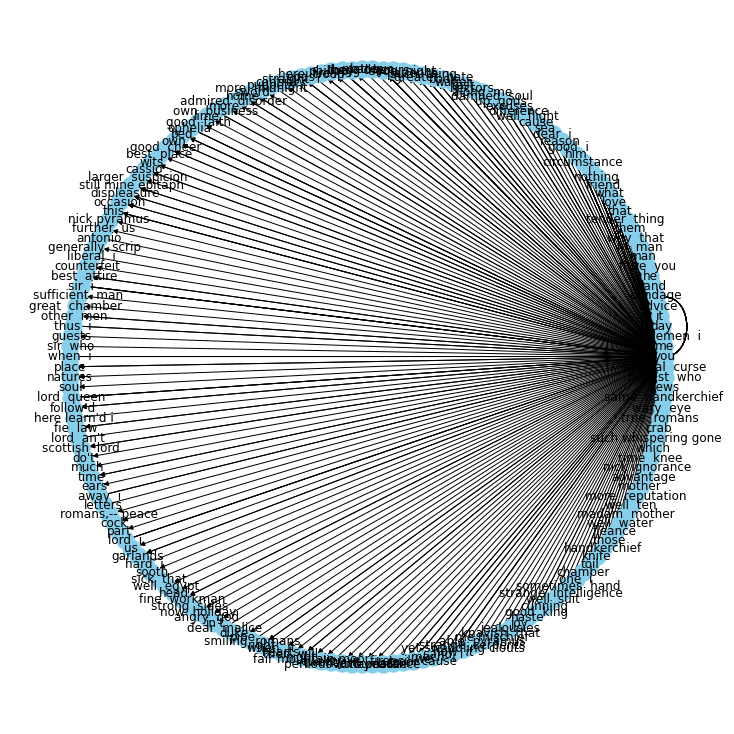

In [ ]:
kg_df_you = kg_df[(kg_df.source == 'you' )|( kg_df.target == 'you')].copy()
print(kg_df_you)

plot_graph(kg_df_you,figsize=(10,10), show_edges=False,use_circular=True)

     source         target    edge
96     they         hearts   steal
113    they           kind    says
400    they  stol'n  jewel     had
415    they          beast    find
424    they           thee  murder
...     ...            ...     ...
7282   they        citadel    give
7436   they           them    seek
7455   they   peloponnesus    fled
7603   they           fray  shield
7639   they          which    made

[65 rows x 3 columns]


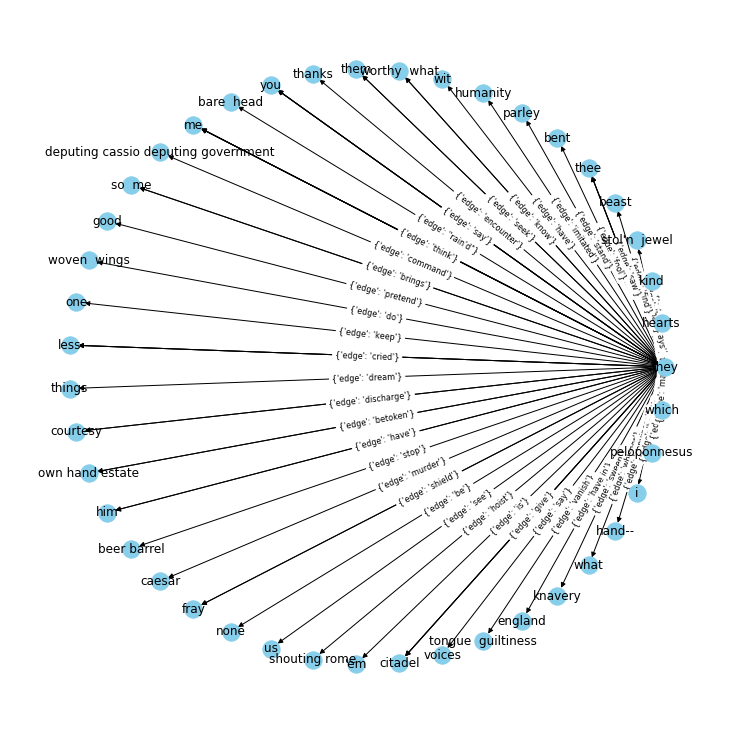

In [ ]:
kg_df_they = kg_df[kg_df.source == 'they'].copy()
print(kg_df_they)

plot_graph(kg_df_they,figsize=(10,10), show_edges=True,use_circular=True)

(49, 3)
49


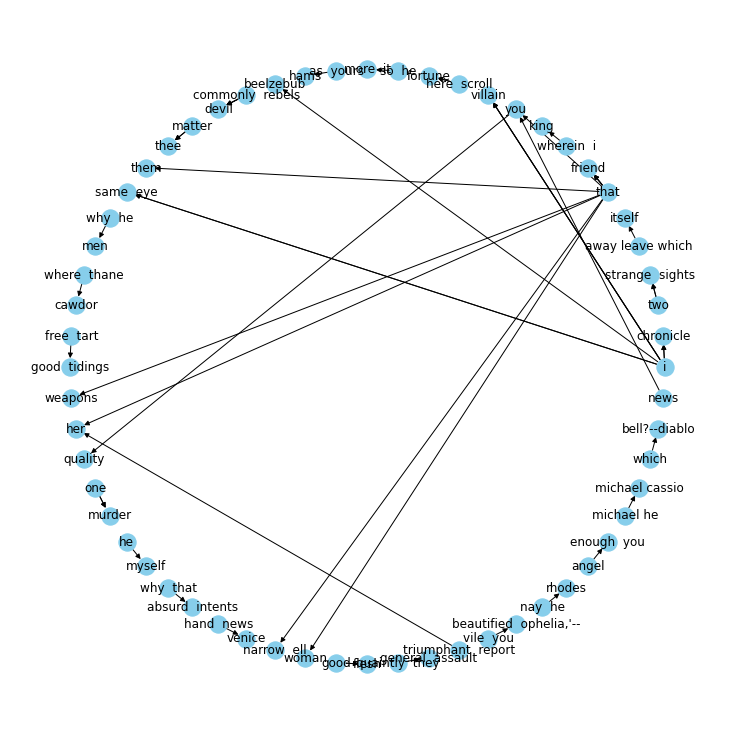

In [ ]:
kg_df_possessive = kg_df[kg_df.edge == "'s"].copy()
print(kg_df_possessive.shape)
print(len(kg_df_possessive))

plot_graph(kg_df_possessive, figsize=(10,10),use_circular=True)

(70, 3)
70


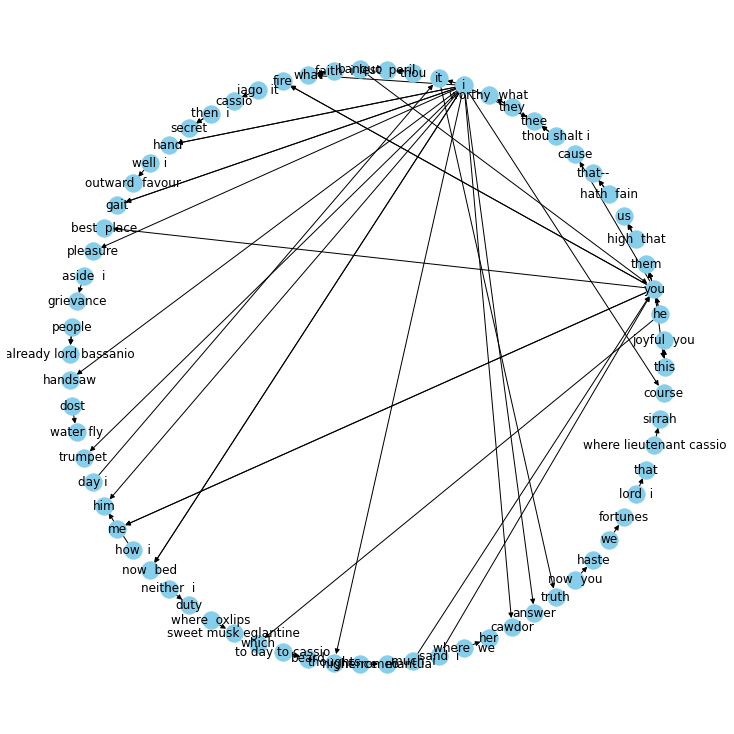

In [ ]:
kg_df_know = kg_df[kg_df.edge == "know"].copy()
print(kg_df_know.shape)
print(len(kg_df_know))

plot_graph(kg_df_know, figsize=(10,10),use_circular=True)

# LSA

In [ ]:
def plot_lsa(processed_textx,number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_textx,number_of_topics,words)

    for doc in processed_textx:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_textx)), playtitles, rotation=90,fontsize=7);
    plt.yticks(range(len(processed_textx)), playtitles,fontsize=7);
    fig.colorbar(cax)
    plt.show()
    return model

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    for x in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
      print(x)
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

In [ ]:
def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

(0, '0.256*"come" + 0.207*"good" + 0.205*"well" + 0.193*"love" + 0.184*"make" + 0.183*"thee" + 0.173*"lord" + 0.171*"man" + 0.158*"let" + 0.152*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.188*"love" + -0.119*"rome" + 0.107*"lord" + 0.107*"romeo" + -0.105*"cassius" + -0.105*"man" + -0.097*"noble"')


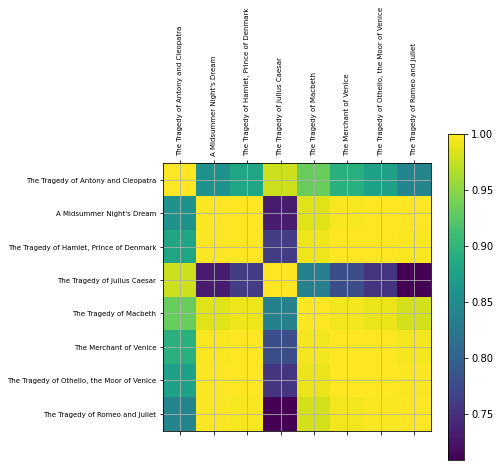

In [ ]:
model_2concepts_10words=plot_lsa(processed_text,2, 10)

(0, '0.256*"come" + 0.207*"good" + 0.205*"well" + 0.193*"love" + 0.184*"make" + 0.183*"thee" + 0.173*"lord" + 0.171*"man" + 0.158*"let" + 0.152*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.188*"love" + -0.119*"rome" + 0.107*"lord" + 0.107*"romeo" + -0.105*"cassius" + -0.105*"man" + -0.097*"noble"')
(2, '-0.392*"lord" + 0.274*"romeo" + 0.254*"love" + 0.219*"thee" + -0.167*"hamlet" + -0.152*"king" + 0.134*"tybalt" + 0.128*"man" + 0.124*"night" + -0.120*"tis"')
(3, '-0.400*"cassio" + 0.244*"lord" + -0.207*"iago" + -0.199*"moor" + 0.197*"hamlet" + 0.193*"king" + -0.141*"desdemona" + 0.138*"like" + -0.135*"think" + -0.121*"honest"')


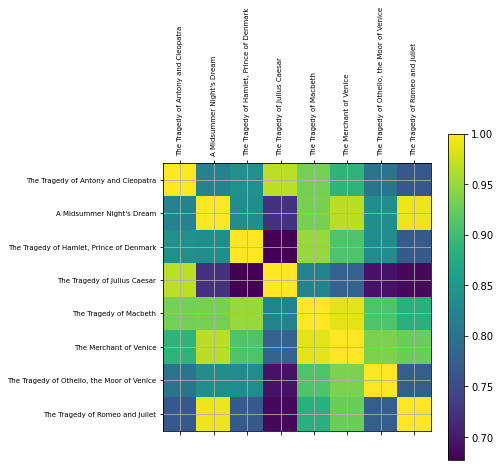

In [ ]:
model_4concepts_10words=plot_lsa(processed_text,4, 10)

(0, '0.256*"come" + 0.207*"good" + 0.205*"well" + 0.193*"love" + 0.184*"make" + 0.183*"thee" + 0.173*"lord" + 0.171*"man" + 0.158*"let" + 0.152*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.188*"love" + -0.119*"rome" + 0.107*"lord" + 0.107*"romeo" + -0.105*"cassius" + -0.105*"man" + -0.097*"noble"')
(2, '-0.392*"lord" + 0.274*"romeo" + 0.254*"love" + 0.219*"thee" + -0.167*"hamlet" + -0.152*"king" + 0.134*"tybalt" + 0.128*"man" + 0.124*"night" + -0.120*"tis"')
(3, '-0.400*"cassio" + 0.244*"lord" + -0.207*"iago" + -0.199*"moor" + 0.197*"hamlet" + 0.193*"king" + -0.141*"desdemona" + 0.138*"like" + -0.135*"think" + -0.121*"honest"')
(4, '0.351*"brutus" + -0.262*"antony" + 0.209*"man" + -0.181*"thee" + -0.164*"make" + -0.144*"madam" + -0.137*"sir" + 0.131*"cassius" + -0.130*"egypt" + 0.120*"doth"')
(5, '0.228*"jew" + -0.187*"brutus" + 0.172*"antonio" + 0.157*"bond" + 0.156*"bassanio" + -0.153*"romeo" + 0.149*"well" + 0.142*"ring" + -0.125*"cassio" + 0.120*"choose"')
(

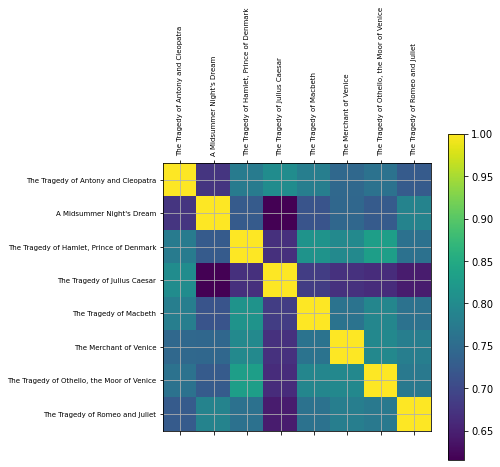

In [ ]:
model_8concepts_10words=plot_lsa(processed_text,8, 10)

In [ ]:
topics = [2,4,8]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'2 concepts 10 words':coherence_values[0],
           '4 concepts 10 words': coherence_values[1],
           '8 concepts 10 words':coherence_values[2]}   

print()
print(coherence)

(0, '0.260*"come" + 0.211*"good" + 0.208*"well" + 0.196*"love" + 0.187*"make" + 0.177*"lord" + 0.174*"man" + 0.161*"let" + 0.155*"know" + 0.155*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.187*"love" + -0.119*"rome" + 0.111*"lord" + -0.105*"cassius" + -0.105*"man" + 0.105*"romeo" + -0.097*"noble"')


(0, '0.260*"come" + 0.211*"good" + 0.208*"well" + 0.196*"love" + 0.187*"make" + 0.177*"lord" + 0.174*"man" + 0.161*"let" + 0.155*"know" + 0.155*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.187*"love" + -0.119*"rome" + 0.111*"lord" + -0.105*"cassius" + -0.105*"man" + 0.105*"romeo" + -0.097*"noble"')
(2, '-0.384*"lord" + 0.278*"romeo" + 0.274*"love" + -0.165*"hamlet" + -0.155*"king" + 0.149*"man" + 0.136*"tybalt" + 0.132*"night" + -0.124*"tis" + 0.105*"death"')
(3, '-0.401*"cassio" + 0.244*"lord" + -0.207*"iago" + -0.199*"moor" + 0.197*"hamlet" + 0.193*"king" + -0.141*"desdemona" + 0.138*"like" + -0.135*"think" + -0.121*"honest"')


(0, '0.260*"come" + 0.211*"good" + 0.208*"well" + 0.196*"love" + 0.187*"make" + 0.177*"lord" + 0.174*"man" + 0.161*"let" + 0.155*"know" + 0.155*"say"')
(1, '-0.606*"caesar" + -0.318*"antony" + -0.294*"brutus" + 0.187*"love" + -0.119*"rome" + 0.111*"lord" + -0.105*"cassius" + -0.105*"man" + 0.105*"romeo" + -0.097*"noble"')
(2, '-0.384*"lord" + 0.278*"romeo" + 0.274*"love" + -0.165*"hamlet" + -0.155*"king" + 0.149*"man" + 0.136*"tybalt" + 0.132*"night" + -0.124*"tis" + 0.105*"death"')
(3, '-0.401*"cassio" + 0.244*"lord" + -0.207*"iago" + -0.199*"moor" + 0.197*"hamlet" + 0.193*"king" + -0.141*"desdemona" + 0.138*"like" + -0.135*"think" + -0.121*"honest"')
(4, '0.340*"brutus" + -0.266*"antony" + 0.193*"man" + -0.166*"make" + -0.146*"madam" + 0.138*"lord" + -0.138*"sir" + -0.131*"romeo" + -0.129*"egypt" + 0.127*"cassius"')
(5, '0.223*"jew" + -0.205*"brutus" + 0.168*"antonio" + 0.153*"bond" + 0.152*"bassanio" + 0.151*"well" + -0.144*"romeo" + 0.138*"ring" + -0.128*"lord" + -0.124*"cassio"')


# LDA

In [ ]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    for x in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
      print(x)
      
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

(0, '0.010*"come" + 0.008*"good" + 0.008*"well" + 0.008*"man" + 0.008*"love" + 0.007*"make" + 0.007*"caesar" + 0.006*"let" + 0.006*"know" + 0.006*"see"')
(1, '0.010*"come" + 0.008*"well" + 0.008*"good" + 0.008*"love" + 0.007*"make" + 0.007*"lord" + 0.007*"man" + 0.006*"say" + 0.006*"let" + 0.006*"know"')


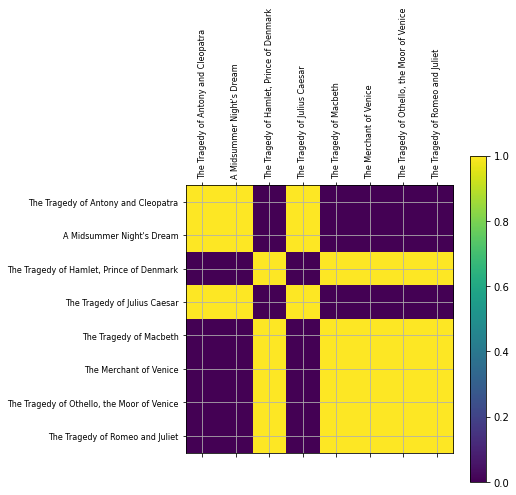

In [ ]:
# Two Topics, 10 Words

lda_model,lda_dict,lda_index,lda_doctermmatrix=create_gensim_lda_model(processed_text,2,10)

for doc in processed_text:
    lda_vec_bow = lda_dict.doc2bow(doc)
    lda_vec = lda_model[lda_vec_bow]  # convert the query to embedded space
    lda_sims = lda_index[lda_vec]  # perform a similarity query against the corpus
    #print(list(enumerate(lda_sims)))  

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(lda_index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), playtitles, rotation=90,fontsize=8);
plt.yticks(range(len(processed_text)), playtitles, fontsize=8);
fig.colorbar(cax)
plt.show()

(0, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.006*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"say" + 0.005*"lord"')
(1, '0.010*"come" + 0.009*"love" + 0.008*"good" + 0.008*"well" + 0.007*"lord" + 0.007*"make" + 0.006*"man" + 0.006*"say" + 0.006*"let" + 0.006*"would"')
(2, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.006*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"say" + 0.005*"lord"')
(3, '0.009*"come" + 0.008*"caesar" + 0.008*"good" + 0.008*"well" + 0.007*"man" + 0.007*"make" + 0.006*"let" + 0.006*"know" + 0.006*"say" + 0.005*"see"')


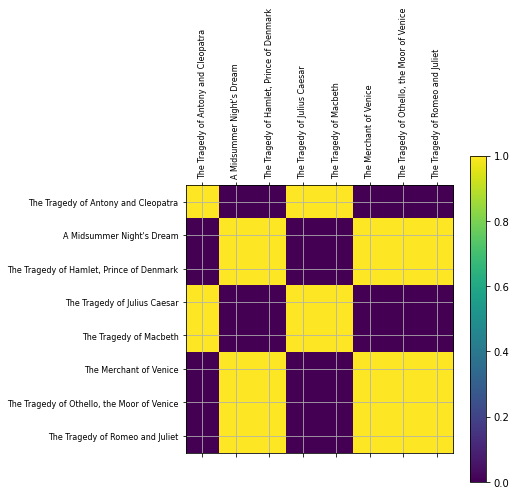

In [ ]:
# Four Topics, 10 Words

lda_model,lda_dict,lda_index,lda_doctermmatrix=create_gensim_lda_model(processed_text,4,10)

for doc in processed_text:
    lda_vec_bow = lda_dict.doc2bow(doc)
    lda_vec = lda_model[lda_vec_bow]  # convert the query to embedded space
    lda_sims = lda_index[lda_vec]  # perform a similarity query against the corpus
    #print(list(enumerate(lda_sims)))  

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(lda_index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), playtitles, rotation=90,fontsize=8);
plt.yticks(range(len(processed_text)), playtitles, fontsize=8);
fig.colorbar(cax)
plt.show()

(0, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(1, '0.011*"love" + 0.011*"come" + 0.008*"well" + 0.007*"man" + 0.007*"good" + 0.007*"make" + 0.006*"say" + 0.006*"would" + 0.005*"see" + 0.005*"let"')
(2, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(3, '0.013*"caesar" + 0.009*"come" + 0.009*"good" + 0.009*"well" + 0.008*"man" + 0.008*"make" + 0.007*"antony" + 0.007*"let" + 0.007*"know" + 0.006*"say"')
(4, '0.009*"come" + 0.008*"good" + 0.008*"well" + 0.008*"love" + 0.007*"make" + 0.007*"know" + 0.006*"say" + 0.006*"lord" + 0.006*"cassio" + 0.006*"let"')
(5, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(6, '0.009*"come" + 0.007*"good" + 0.007*"make" + 0.006*"well" + 0.006*"upon" + 0

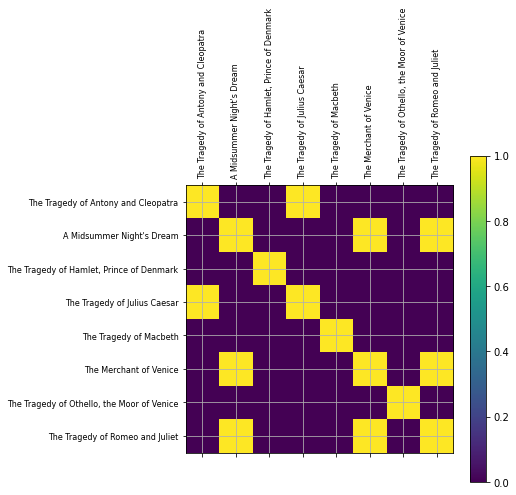

In [ ]:
# Eight Topics, 10 Words

lda_model,lda_dict,lda_index,lda_doctermmatrix=create_gensim_lda_model(processed_text,8,10)

for doc in processed_text:
    lda_vec_bow = lda_dict.doc2bow(doc)
    lda_vec = lda_model[lda_vec_bow]  # convert the query to embedded space
    lda_sims = lda_index[lda_vec]  # perform a similarity query against the corpus
    #print(list(enumerate(lda_sims)))  

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(lda_index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), playtitles, rotation=90,fontsize=8);
plt.yticks(range(len(processed_text)), playtitles, fontsize=8);
fig.colorbar(cax)
plt.show()

In [ ]:
topics = [2,4,8]
lda_coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    lda_coherence_values.append(coherence_lda)

    
lda_coherence ={'2 topic 10 words':lda_coherence_values[0],
                '4 topic 10 words': lda_coherence_values[1],
                '8 topic 10 words':lda_coherence_values[2]}   

print()
print(lda_coherence)

(0, '0.010*"come" + 0.008*"good" + 0.008*"well" + 0.008*"man" + 0.008*"love" + 0.007*"make" + 0.007*"caesar" + 0.006*"let" + 0.006*"know" + 0.006*"see"')
(1, '0.010*"come" + 0.008*"well" + 0.008*"good" + 0.008*"love" + 0.007*"make" + 0.007*"lord" + 0.007*"man" + 0.006*"say" + 0.006*"let" + 0.006*"know"')


(0, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.006*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"say" + 0.005*"lord"')
(1, '0.010*"come" + 0.009*"love" + 0.008*"good" + 0.008*"well" + 0.007*"lord" + 0.007*"make" + 0.006*"man" + 0.006*"say" + 0.006*"let" + 0.006*"would"')
(2, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.006*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"say" + 0.005*"lord"')
(3, '0.009*"come" + 0.008*"caesar" + 0.008*"good" + 0.008*"well" + 0.007*"man" + 0.007*"make" + 0.006*"let" + 0.006*"know" + 0.006*"say" + 0.005*"see"')


(0, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(1, '0.011*"love" + 0.011*"come" + 0.008*"well" + 0.007*"man" + 0.007*"good" + 0.007*"make" + 0.006*"say" + 0.006*"would" + 0.005*"see" + 0.005*"let"')
(2, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(3, '0.013*"caesar" + 0.009*"come" + 0.009*"good" + 0.009*"well" + 0.008*"man" + 0.008*"make" + 0.007*"antony" + 0.007*"let" + 0.007*"know" + 0.006*"say"')
(4, '0.009*"come" + 0.008*"good" + 0.008*"well" + 0.008*"love" + 0.007*"make" + 0.007*"know" + 0.006*"say" + 0.006*"lord" + 0.006*"cassio" + 0.006*"let"')
(5, '0.008*"come" + 0.006*"good" + 0.006*"well" + 0.006*"make" + 0.005*"man" + 0.005*"love" + 0.005*"let" + 0.005*"know" + 0.005*"lord" + 0.005*"say"')
(6, '0.009*"come" + 0.007*"good" + 0.007*"make" + 0.006*"well" + 0.006*"upon" + 0